## IMPORTS

## Image pre-processing for efficiency

In [1]:
import os
from PIL import Image
from math import sqrt

import PIL
import torch

from cv2 import cv2
import numpy as np
import pandas as pd

import fastai
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.vision.core import *
from fastai.vision import models

from matplotlib import pyplot as plt
import matplotlib as mpl

# For displaying images in HD
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

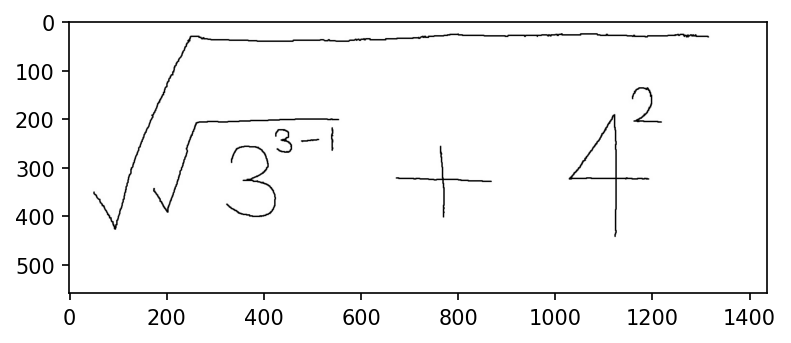

In [2]:
# MODEL AND INPUT IMAGE PATH
model_path = r'/notebooks/storage/Crohme_dataset16_split/resnet34-untuned.pkl'

# PATH FOR IMAGE CAPTURED BY A CAMERA
img_path = r'/notebooks/storage/hard_sqrt.jpg'

# READ IMAGE
img_obj = cv2.imread(img_path)
plt.imshow(img_obj)
plt.show()

# CONVERT IMAGE TO GRAYSCALE AND ADD GAUSSIAN BLUR
gray_img = cv2.cvtColor(img_obj, cv2.COLOR_BGR2GRAY)

# CONVERT IMAGE TO BINARY
_, thd_image = cv2.threshold(gray_img, 90, 255, cv2.THRESH_BINARY_INV)

## Calculation of Aspect Ratio of Contours
Calculate the aspect ratio of the contour rectangles
so that it could be changed to that of the training data set.

In [3]:
def calc_aspect(s_img):

    # ASPECT RATIO OF THE SYMBOL IMAGE
    s_aspect = s_img.shape[1]/s_img.shape[0]

    if s_aspect < 1:    # IF Y > X
        x_length = s_aspect * square_side
        # IN RESIZE, DIMENSION IS GIVEN AS (X, Y)
        s_img = cv2.resize(s_img, (int(x_length), square_side), interpolation=cv2.INTER_AREA)

        # X AND Y OFFSETS TO MAKE IMAGE CENTERED IN X AXIS
        x_offset = (square_side/2) - (s_img.shape[1]/2)
        y_offset = 0

    elif s_aspect > 1:    # IF Y < X
        y_length = square_side/s_aspect
        s_img = cv2.resize(s_img, (square_side, int(y_length)), interpolation=cv2.INTER_AREA)

        # Y - OFFSET TO MAKE IMAGE CENTERED IN Y AXIS
        x_offset = 0
        y_offset = (square_side/2) - (s_img.shape[0]/2)

    return x_offset, y_offset, s_img

## Contour Detection

In [4]:
# 'contours' IS A 3D NUMPY ARRAY OF PIXEL
# CO-ORDINATES OF THE DETECTED CONTOURS
contours, _ = cv2.findContours(thd_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

Scanning for contours.
(672, 256)
(404, 330.0)


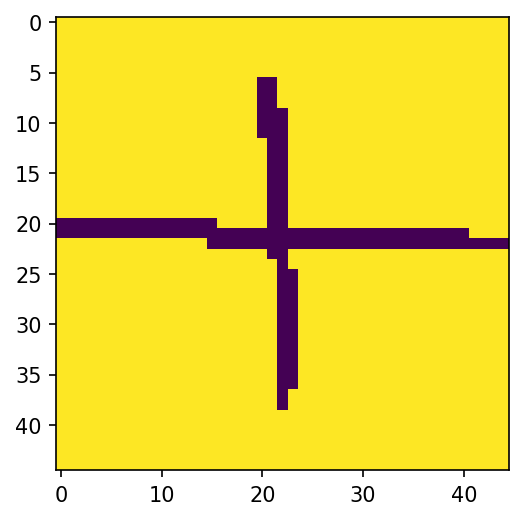

(323, 256)
(403, 329.5)


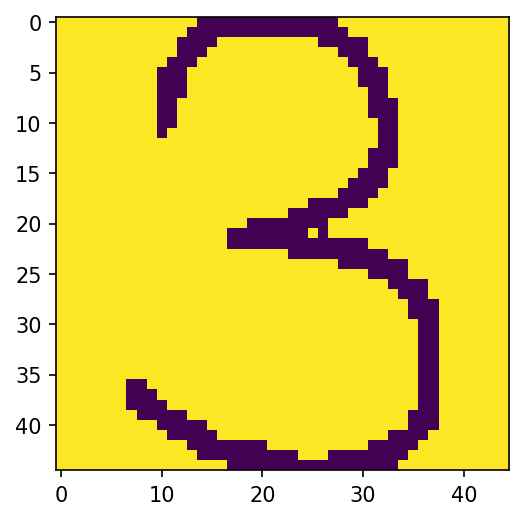

(477, 242)
(249, 245.5)


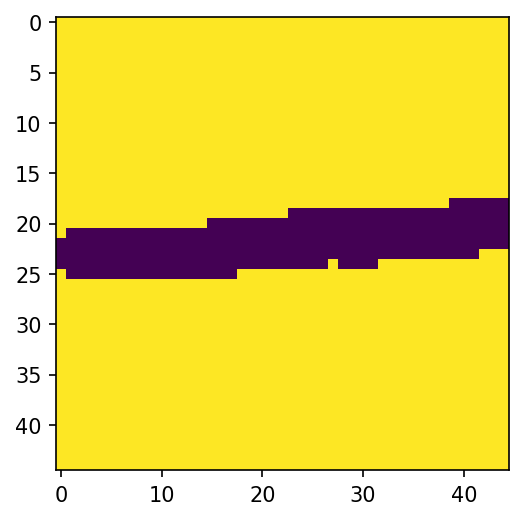

(424, 222)
(271, 246.5)


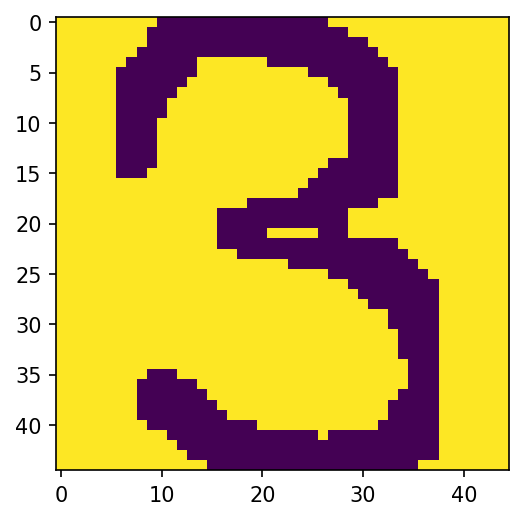

(539, 218)
(267, 242.5)


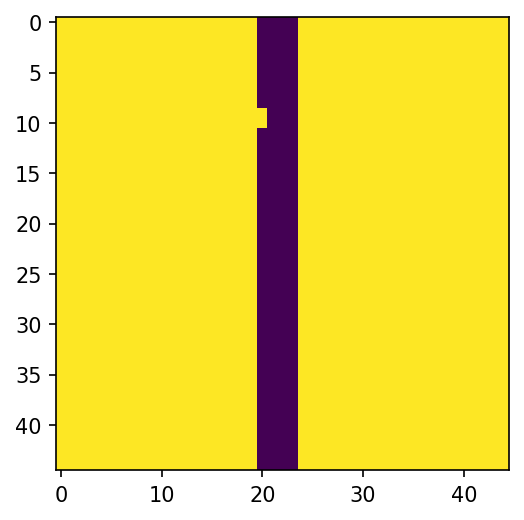

(173, 200)
(394, 297.0)


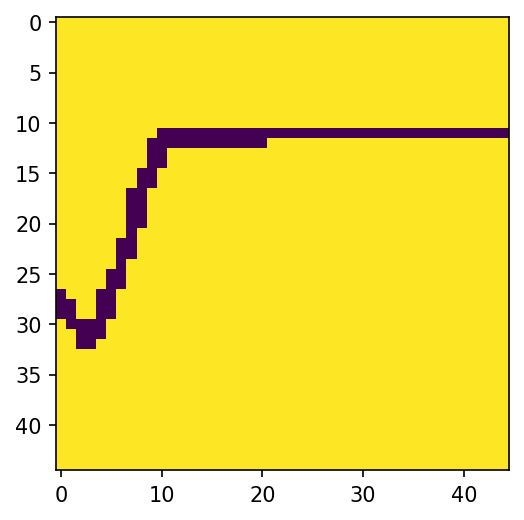

(1028, 191)
(444, 317.5)


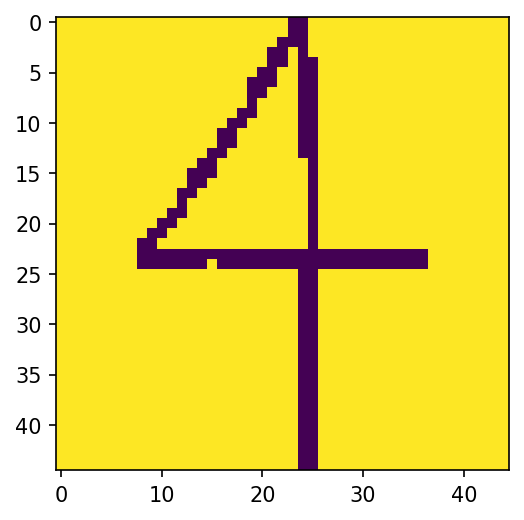

(1158, 136)
(209, 172.5)


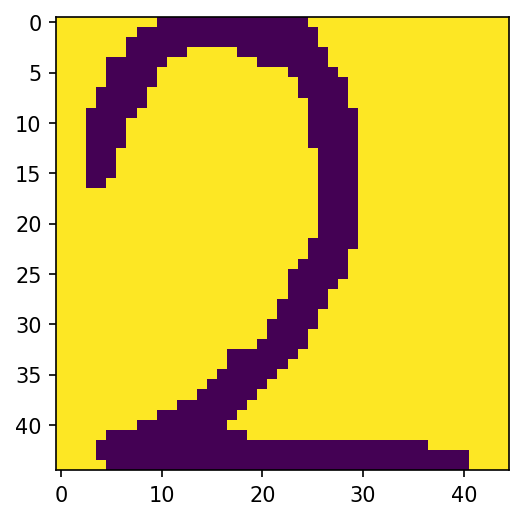

(50, 25)
(429, 227.0)


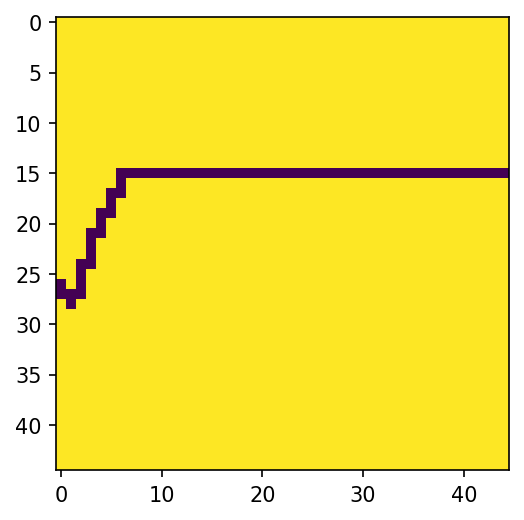

Contours scanned.


In [5]:
# CONTOUR IMAGE SIZE (CONTROLS DEGREE OF DETAIL OF CONTOUR)
square_side = 45
# 'BRUSH' SIZE TO DRAW CONTOURS
dot_size = 2

print("Scanning for contours.")

black_dot = 0                               # TO DRAW THE CONTOURS
ctr_img_data = []                           # LIST OF ALL IMAGES OF INDIVIDUAL CONTOURS AND POSITION IN THE X-AXIS

# CONTOURS IS A LIST OF ALL THE CONTOURS
for contour in contours:                    # 'contour' IS A 2D NUMPY ARRAY
    contour_data = []                       # LIST THAT HOLDS DICTIONARIES OF PIXEL CO-ORDINATES OF A CONTOUR
    for element in contour:                 # 'element' IS A LIST OF ONE 'PYTHON - LIST' (FOR GRAY-SCALE IMAGE I GUESS..)
        for pixel_co in element:            # 'pixel_co' IS A 'PYTHON - LIST' OF X AND Y CO-ORDINATES OF A CONTOUR

            # APPENDING CO-ORDINATES OF PIXELS OF THE CONTOUR TO A LIST
            contour_data.append({'X':pixel_co[0], 'Y':pixel_co[1]})

    # TEMPORARY DATAFRAME TO CALCULATE SIZE OF TEMPORARY IMAGE
    # AND ALSO TO USE CO-ORDINATES STORED TO DRAW THE CONTOUR
    temp_df = pd.DataFrame(ctr_data for ctr_data in contour_data)

    # TO GET DIMENSIONS OF RECTANGLES SURROUNDING CONTOURS
    x_min = temp_df['X'].min()
    x_max = temp_df['X'].max()
    x_mid = (x_max - x_min)/2 + x_min
    y_min = temp_df['Y'].min()

    xy_min = (x_min, y_min)
    print(str(xy_min))

    # SUBTRACT MIN X AND MIN Y TO GET CO-ORDINATES
    # OF THE CONTOUR WITH RESPECT TO ORIGIN 0,0
    offset_sub = pd.Series([x_min, y_min], index =['X', 'Y'])
    temp_df = temp_df.subtract(offset_sub, axis=1)
    
    # STORES ALL INDEXES IN index
    index = temp_df.index
    tot_rows = len(index)
    
    # HEIGHT AND WIDTH OF TEMPORARY IMAGE WHERE CONTOUR MUST BE DRAWN
    x_size = temp_df['X'].max() + 1
    y_size = temp_df['Y'].max() + 1

    # TO STORE VERTICAL POSITION OF CONTOURS
    y_max = y_min + y_size
    y_mid = ((y_max - y_min)/2) + y_min
    
    yt = (y_max, y_mid)
    print(str(yt))
    
    # TEMPORARY IMAGE WHERE CONTOUR GETS DRAWN
    temp_img = np.zeros([x_size,y_size],dtype=np.uint8)
    temp_img.fill(255)

    temp_img = cv2.rotate(temp_img, cv2.ROTATE_90_CLOCKWISE)

    i = 0
    while i < tot_rows:
        x = temp_df.loc[i]['X']             # X - CO-ORDINATE FOR DOT TO DRAW
        y = temp_df.loc[i]['Y']             # Y - CO-ORDINATE FOR DOT TO DRAW

        # DRAWS CONTOUR TO IMAGE
        temp_img[y:y + dot_size, x:x + dot_size] = black_dot

        i += 1

    # CALCULATE ASPECT RATIO TO RESIZE THE IMAGE AND RETURNS OFFSETS FOR X AND
    # Y TO POSITION IMAGE IN THE CENTRE. IT ALSO RETURNS THE RESIZED IMAGE
    x_offset, y_offset, s_img = calc_aspect(temp_img)

    # WHITE BACKGROUND ON TOP OF WHICH THE PICTURE
    # OF THE CONTOUR IS TO BE PASTED
    f_img = np.zeros([square_side, square_side],dtype=np.uint8)
    f_img.fill(255)

    # PASTE CONTOUR IMAGE ON TOP OF THE WHITE BACKGROUND
    f_img[int(y_offset):int(y_offset) + s_img.shape[0], int(x_offset):int(x_offset) + s_img.shape[1]] = s_img

    # SHARPEN IMAGE BY THRESHOLDING OPERATION
    f_img = cv2.bitwise_not(f_img)
    _, f_img = cv2.threshold(f_img, 1, 255, cv2.THRESH_BINARY_INV)

    # SHOW THE CONTOURS
    plt.imshow(f_img)
    plt.show()
    # RESIZING IMAGE TO BE COMPARABLE TO MODEL
    f_img = cv2.resize(f_img, (45, 45), interpolation=cv2.INTER_AREA)

    # STORE IMAGES IN A LIST
    ctr_img_data.append([f_img, x_min, x_max, x_mid, y_mid, y_min, y_max])

print("Contours scanned.")

## PREDICTOR

In [7]:
import torch

In [8]:
image_data = ctr_img_data
print("Predicting values.")

# DATAFRAME TO SORT VALUES AND POSITION OF VALUE
# IN X-AXIS FOR CALCULATION FROM LEFT TO RIGHT
values_df = pd.DataFrame(data = None, columns = ['Value', 'X-Pos', 'X-Max', 'X-Mid', 'Y-Mid', 'Y-Min', 'Y-Max'])

# LOAD NNW MODEL
learn1 = load_learner(model_path)

for img in image_data:
    #print(img[0].shape*)
    rgb_img = cv2.cvtColor(img[0], cv2.COLOR_GRAY2RGB)
    r_im = cv2.resize(rgb_img, (224, 224))
    #print("2", r_im.dtype, r_im.shape)
    
    # MAKING IMAGE OBJECT OUT OF ARRAY
    #new_im = Image.fromarray(rgb_img)
    #new = Image.fromarray((255*rgb_img.permute(1, 2, 0)).numpy().astype(np.uint8))
    #new_im.save('temp_img.png')
    
    # OPEN IMAGE USING FAST AI
    fst_img = torch.from_numpy(r_im)
    #fst_img = open_image('temp_img.png')
    #print("3",fst_img.dtype, fst_img.shape)
    
    # PREDICTED VALUE
    value = learn1.predict(fst_img)
    value = str(value[0])
    print(value)

    #APPENDING DETECTED VALUES WITH POSITIONS AND VERTICAL MID-POINT
    values_df = values_df.append({'Value':value, 'X-Pos':img[1], 'X-Max':img[2], 'X-Mid':img[3], 'Y-Mid':img[4], 'Y-Min':img[5], 'Y-Max':img[6]}, ignore_index=True)

#os.remove('temp_img.png')

print("Values predicted.")

Predicting values.


+


3


-


3


1


sqrt


4


2


sqrt
Values predicted.


## Result Evaluation

In [9]:
dataframe = values_df
print("Calculating result.")

result = ''
# STACK FOR PARENTHESIS BALANCING
stack = 0
# SORTING THE VALUE FOR APPROPRIATE RESULT (FROM LEFT TO RIGHT)
dataframe.sort_values(by=['X-Pos'], inplace=True, ignore_index=True)
print(dataframe)

# TO COUNT NUMBER OF SYMBOLS
index = dataframe.index

sqrt_check = 0
sqrt_max = 0
i = 0
# ITERATE FOR ALL SYMBOLS
while i < len(index):

    # TO CHECK FOR EQUIVALENCE
    if dataframe.loc[i]['Value'] == '-':
        if dataframe.loc[i]['X-Mid'] > sqrt_max and sqrt_check == 1:
            result += ')'
            stack -= 1
            sqrt_check = 0
        if dataframe.loc[i + 1]['Value'] == '-':
            result += '=='
            i += 2
            continue
        
        result += '-'
        i += 1
        continue
    
    # FOR MULTIPLICATION SIGN
    if dataframe.loc[i]['Value'] == 'times':
        result += '*'
        i += 1
        continue
    
    # FOR SQUARE ROOT
    if dataframe.loc[i]['Value'] == 'sqrt':
        result += 'sqrt('
        stack += 1
        sqrt_check = 1
        sqrt_max = dataframe.loc[i]['X-Max']
        i += 1
        continue
    
    if dataframe.loc[i]['X-Mid'] > sqrt_max and sqrt_check == 1:
        result += ')'
        stack -= 1
        sqrt_check = 0
        
    try:
        if dataframe.loc[i]['Y-Mid'] >= dataframe.loc[i + 1]['Y-Max'] and dataframe.loc[i + 1]['Value'] != '-':
            result += dataframe.loc[i]['Value'] + '**('
            stack += 1
            i += 1
        elif dataframe.loc[i + 1]['Y-Mid'] >= dataframe.loc[i]['Y-Max']:
            result += dataframe.loc[i]['Value'] + ')'
            stack -= 1
            i += 1
        else:
            result += dataframe.loc[i]['Value']
            i += 1

    except KeyError:
        result += dataframe.loc[i]['Value']

        while stack != 0:
            result += ')'
            stack -= 1

        print("End of result string..")
        break

# RESULT STRING
print(result)

try:
    # FINAL RESULT AFTER EVALUATION
    print("RESULT: " + str(eval(result)))

# IF CONTOUR RESULTS IN A NON MATH SYMBOL (WON'T OCCUR IN MATH SYMBOL DATASET)
except NameError:
    print("Could not calculate result of expression (Name Error).")
# IF RESULT IS SYNTACTICALLY INCORRECT
except SyntaxError:
    print("Could not calculate result of expression (Syntax Error).")

Calculating result.
  Value X-Pos X-Max   X-Mid  Y-Mid Y-Min Y-Max
0  sqrt    50  1316   683.0  227.0    25   429
1  sqrt   173   555   364.0  297.0   200   394
2     3   323   425   374.0  329.5   256   403
3     3   424   458   441.0  246.5   222   271
4     -   477   514   495.5  245.5   242   249
5     1   539   543   541.0  242.5   218   267
6     +   672   869   770.5  330.0   256   404
7     4  1028  1193  1110.5  317.5   191   444
8     2  1158  1219  1188.5  172.5   136   209
End of result string..
sqrt(sqrt(3**(3-1))+4**(2))
RESULT: 4.358898943540674


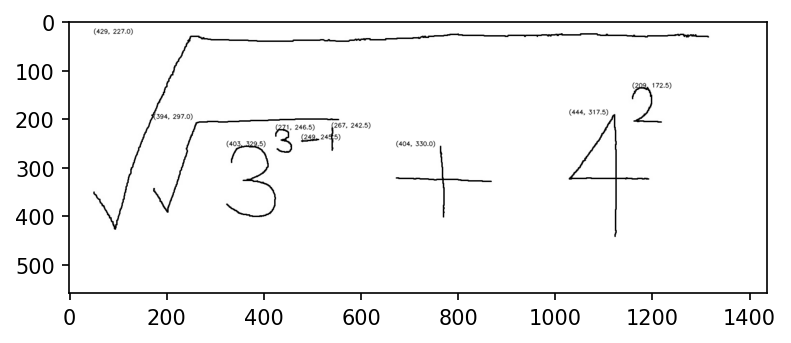

In [10]:
color = (0, 0, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.4
thickness = 1

op_image = img_obj

for i in dataframe.index:
    coordinates = (dataframe.loc[i]['X-Pos'], dataframe.loc[i]['Y-Min'])
    text = (dataframe.loc[i]['Y-Max'], dataframe.loc[i]['Y-Mid'])

    op_image = cv2.putText(op_image, str(text), coordinates, font, fontScale, color, thickness, cv2.LINE_AA)

plt.imshow(op_image)
plt.show()